In [139]:
import pymc3 as pm
import custom_funcs as cf
import theano
import theano.tensor as T
import seaborn as sns

from theano.tensor.nnet import relu

# Load Data

In [103]:
drugs = ['FPV', 'ATV', 'IDV', 'LPV', 'NFV', 'SQV', 'TPV', 'DRV',]
drug = drugs[0]
protein = 'protease'

data, feat_cols = cf.get_cleaned_data(protein, drug)

# Just checking:
cf.test_data_integrity(data)

## Now, let's do data transformations.
data_numeric = cf.to_numeric_rep(data, feat_cols, rep='mw')

# Finally, split the data into a training set, and test set.
X, Y, X_train, X_test, Y_train, Y_test = cf.to_train_test_split(data_numeric, feat_cols, drug, test_size=0.3)
Y = Y.reshape(Y.shape[0], 1)
# sscv = ShuffleSplit(n=len(X_train), n_iter=3, test_size=0.3)

In [104]:
Y.shape

(726, 1)

# Define Linear Model

In [105]:
linreg_input = theano.shared(X_train.values)
linreg_output = theano.shared(Y_train.values)

with pm.Model() as linreg:
    weights = pm.Normal('weights', 10, sd=1, shape=(X.shape[1], Y.shape[1]))
    biases = pm.Normal('biases', 0, sd=1, shape=(Y.shape[1]))
    error = pm.Normal('error', 0, sd=1, shape=(Y.shape[1]))
    
    predictions = pm.Normal('Y', T.dot(linreg_input, weights) + biases + error, observed=linreg_output)

In [117]:
import numpy as np
minibatch_tensors = [linreg_input, linreg_output]
minibatch_RVs = [predictions]

# Generator that returns mini-batches in each iteration
def create_minibatch(data):
    rng = np.random.RandomState(0)

    while True:
        # Return random data samples of set size 100 each iteration
        ixs = rng.randint(len(data), size=50)
        yield data[ixs]

minibatches = zip(
    create_minibatch(X_train.values),
    create_minibatch(Y_train.values),
)

total_size = len(Y_train.values)

In [123]:
# %%time

# with linreg:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
#     v_params = pm.variational.advi(n=50000)
    
    
with linreg:
    # Run advi_minibatch
    v_params = pm.variational.advi_minibatch(
        n=200000, minibatch_tensors=minibatch_tensors,
        minibatch_RVs=minibatch_RVs, minibatches=minibatches,
        total_size=total_size, learning_rate=1e-2, epsilon=1.0,
        verbose=2,
    )

Iteration 0 [0%]: ELBO = -202820928019107.9
Iteration 20000 [10%]: Average ELBO = -10520264234183.95
Iteration 40000 [20%]: Average ELBO = -8410363.1
Iteration 60000 [30%]: Average ELBO = -8962193.56
Iteration 80000 [40%]: Average ELBO = -9419325.04
Iteration 100000 [50%]: Average ELBO = -9758423.41
Iteration 120000 [60%]: Average ELBO = -9762959.37
Iteration 140000 [70%]: Average ELBO = -9985662.67
Iteration 160000 [80%]: Average ELBO = -10176564.28
Iteration 180000 [90%]: Average ELBO = -10375151.38
Finished [100%]: ELBO = -37601.72


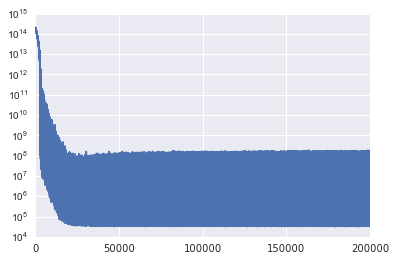

In [140]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(-v_params.elbo_vals)
plt.yscale('log')
sns.despine()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1702d95c0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1701f97b8>]], dtype=object)

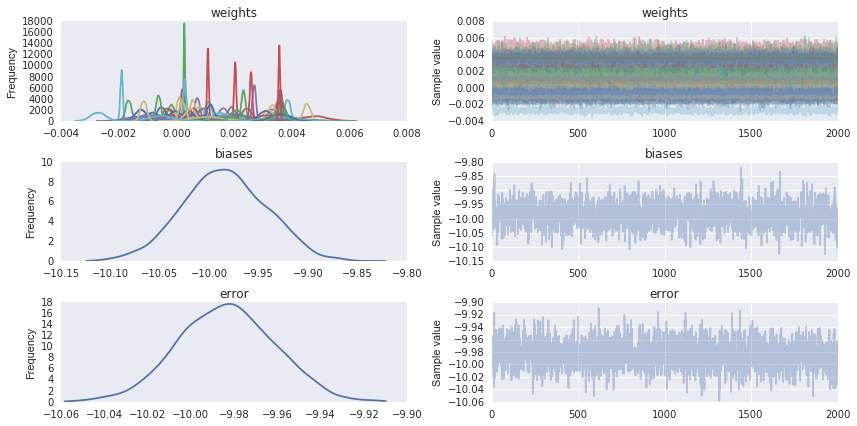

In [142]:
with linreg:
    trace = pm.variational.sample_vp(v_params, draws=2000)
    
pm.traceplot(trace)
# sns.despine()

<Container object of 3 artists>

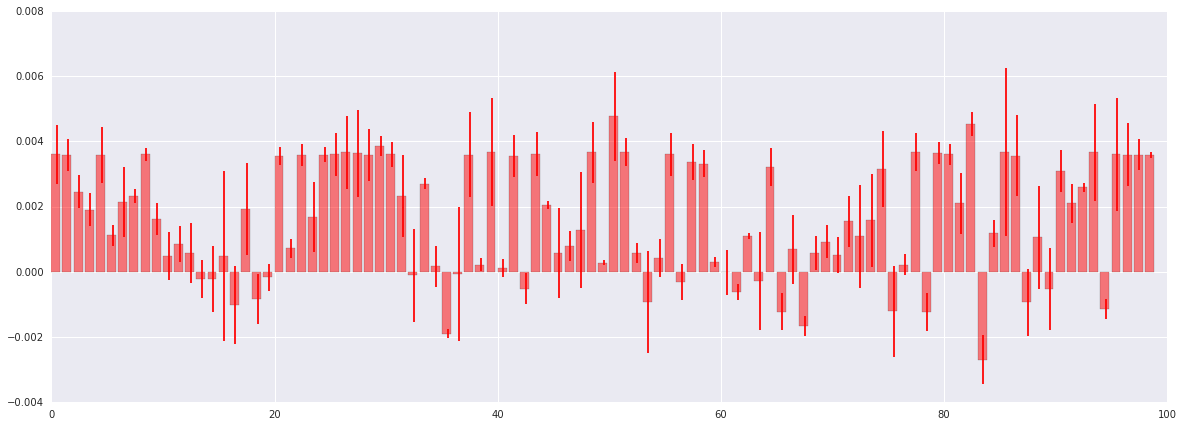

In [143]:
fig = plt.figure(figsize=(20, 7))
means = v_params.means['weights']
stds = v_params.stds['weights']
errors = stds * 3

plt.bar(np.arange(len(means)), means, color='red', alpha=0.5)
# plt.bar(np.arange(len(means))+0.5, means, color='blue', alpha=0.5)
plt.errorbar(np.arange(len(means))+0.5, means, color='r', yerr=errors, ls='none')

In [148]:
v_params.means['weights']

array([[  3.60403607e-03],
       [  3.58039873e-03],
       [  2.45891670e-03],
       [  1.90680674e-03],
       [  3.59041379e-03],
       [  1.11091955e-03],
       [  2.14578768e-03],
       [  2.32592072e-03],
       [  3.60403600e-03],
       [  1.62817814e-03],
       [  4.69704775e-04],
       [  8.35010605e-04],
       [  5.69700485e-04],
       [ -2.17635230e-04],
       [ -2.29564304e-04],
       [  4.90131716e-04],
       [ -1.03408549e-03],
       [  1.92137728e-03],
       [ -8.40972922e-04],
       [ -1.74619866e-04],
       [  3.55374473e-03],
       [  7.19143818e-04],
       [  3.59041375e-03],
       [  1.67444199e-03],
       [  3.58899643e-03],
       [  3.60030649e-03],
       [  3.66348290e-03],
       [  3.63658786e-03],
       [  3.58899651e-03],
       [  3.85792728e-03],
       [  3.60030647e-03],
       [  2.33004656e-03],
       [ -1.16209946e-04],
       [  2.69835364e-03],
       [  1.68424474e-04],
       [ -1.90278896e-03],
       [ -6.72948728e-05],
 

<Container object of 3 artists>

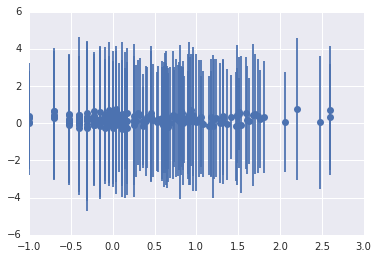

In [150]:
linreg_input.set_value(X_test)
linreg_output.set_value(Y_test)

ppc = pm.sample_ppc(trace, model=linreg, samples=20)

ycol = 0
ys = Y_test
preds = ppc['Y'].mean(axis=0)
yerr = ppc['Y'].std(axis=0) * 3
plt.errorbar(ys, preds, yerr=yerr, ls='none', marker='o')

# Simple Neural Network

In [182]:
ann_input = theano.shared(X_train.values)
ann_output = theano.shared(Y_train.values)

n_hidden1 = 20
n_hidden2 = 10

with pm.Model() as ann:
    weights1 = pm.Normal('weights1', mu=0, sd=1, shape=(X.shape[1], n_hidden1))
    output1 = relu(T.dot(ann_input, weights1))
    
    weights2 = pm.Normal('weights2', mu=0, sd=1, shape=(n_hidden1, n_hidden2))
    output2 = relu(T.dot(output1, weights2))
    
    lr_weights = pm.Normal('linreg_weights', mu=0, sd=1, shape=(n_hidden2, 1))
    output3 = relu(T.dot(output2, lr_weights))
    
    predictions = pm.Normal('predictions', mu=output3, observed=ann_output)

In [183]:
%%time


minibatch_tensors = [ann_input, ann_output]
minibatch_RVs = [predictions]


with ann:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    v_params = pm.variational.advi_minibatch(n=200000, minibatch_tensors=minibatch_tensors,
                                             minibatch_RVs=minibatch_RVs, minibatches=minibatches,
                                             total_size=total_size, learning_rate=1e-2, epsilon=1.0,
                                             verbose=2,
                                             )

Iteration 0 [0%]: ELBO = -1346663582190.42
Iteration 20000 [10%]: Average ELBO = -49129498159.91
Iteration 40000 [20%]: Average ELBO = -50396134621.92
Iteration 60000 [30%]: Average ELBO = -41419710658.65
Iteration 80000 [40%]: Average ELBO = -51440304338.93
Iteration 100000 [50%]: Average ELBO = -46200267376.82
Iteration 120000 [60%]: Average ELBO = -48324050868.24
Iteration 140000 [70%]: Average ELBO = -48158810685.75
Iteration 160000 [80%]: Average ELBO = -49397995236.18
Iteration 180000 [90%]: Average ELBO = -50279701443.04
Finished [100%]: ELBO = -30357.7
CPU times: user 3min 8s, sys: 1.56 s, total: 3min 10s
Wall time: 1min 37s


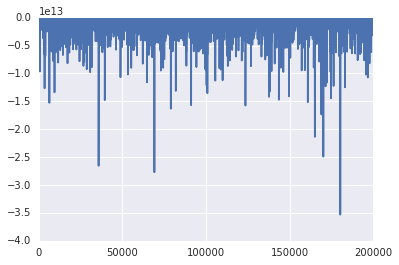

In [184]:
plt.plot(v_params.elbo_vals)
# plt.yscale('log')

In [185]:
with ann:
    trace = pm.variational.sample_vp(v_params, draws=500)
    
# pm.traceplot(trace)

In [186]:
trace['linreg_weights'].mean(axis=0)

array([[-0.55472939],
       [-0.58124201],
       [-0.54708073],
       [-0.70870391],
       [-0.4776628 ],
       [-0.39046772],
       [-0.41254946],
       [-0.72321106],
       [-0.44527393],
       [-0.49696784]])

In [187]:
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

<Container object of 3 artists>

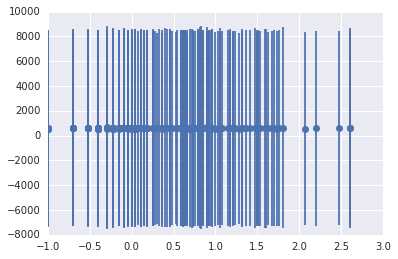

In [203]:
ppc = pm.sample_ppc(trace, model=ann, samples=100)

ycol = 0
ys = Y_test
preds = ppc['predictions'].mean(axis=0)
yerr = ppc['predictions'].std(axis=0) * 3
plt.errorbar(ys, preds, yerr=yerr, ls='none', marker='o')
# plt.ylim(-1, 1)

In [ ]:
# with ann:
#     v_params = pm.variational.advi_minibatch(n=50000, minibatch_tensors=minibatch_tensors,
#                                              minibatch_RVs=minibatch_RVs, minibatches=minibatches,
#                                              total_size=total_size)